In [1]:
import numpy as np
import pickle
import sys
from typing import List
import torch
import os

In [2]:
participant_data_path = './EEG/number'
processed_data_path = './EEG/processed_data'
split_data_path = './EEG/split_data'

In [3]:
ps = os.listdir(participant_data_path)
participants=[]
for p in ps:
    p= p[:3]
    if p not in participants:
        participants.append(p)
        
participants= sorted(participants)
# participants, len(participants)

In [4]:
load_name=f"userfold_data_scaled_p_dictionary-number"
data_dir = "./EEG/split_data/standard_scaled"
try:
    raw_user_fold= pickle.load(open(os.path.join(data_dir, f"{load_name}.pkl"), "rb"))
except:
    print(f"pickle file does not exist. Use EEG-Preprocess.ipynb and EEG-Split.ipynb to save data setting.")
    sys.exit()

In [ ]:
from utilities.userfold_framework import *
from utilities.EEG_func import *
import Models.model_func as Model_Func
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List
from torcheeg.models import EEGNet
# import Models.model_func as Model_Func
from torch import nn
from Models.multi_models import *

DEVICE= torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

learning_rate = 0.00005
batch_size = 64
n_epochs = 300
transpose_channels=True
participants_dictionary=[]
# participants_online_dictionary=[]
participants_grads_dictionary={}
b_acc_list=[]
c0_acc_list=[]
c1_acc_list=[]

class LSTM_output(torch.nn.Module):
    def forward(self, x):
        return x[0].unsqueeze(0)


for i in range(len(participants)):

    train_dataloader, val_dataloader, classes, input_dim, class_ratio= user_fold_load(i,
                                                                                      raw_user_fold,
                                                                                      participants,
                                                                                      batch_size=batch_size,
                                                                                      transpose_channels=transpose_channels)

    classifier= EEGNet(
        chunk_size=input_dim[1],
        num_electrodes=input_dim[0],
        num_classes=classes,
        kernel_1= 32,
        kernel_2=32,
        F1=8,
        F2=16,
        dropout=0.5
    ).to(DEVICE)
    
#     resnet = ResNetPlus(input_dim[0], classes, bn_1st=False)
#     softmax_activation = nn.LogSoftmax(dim=1)
#     classifier = nn.Sequential(resnet, softmax_activation).to(DEVICE)

    
#     classifier = DataGliderBasic_Model(DEVICE, input_dim, classes)
#     classifier.to(DEVICE)
    
#     optimizer= torch.optim.RMSprop(classifier.parameters(), lr=learning_rate)
    
    
    criterion= torch.nn.CrossEntropyLoss(weight=torch.tensor(class_ratio, dtype=torch.float).to(DEVICE))
#     criterion = nn.NLLLoss(weight=torch.tensor(class_ratio, dtype=torch.float).to(DEVICE))
        
    saved_dir= "./EEG/saved_models/Userfold/run0"
    nonlinear_func= torch.nn.Sequential(
#                     LSTM_input(),
                    torch.nn.LSTM(input_dim[1],input_dim[1]),
                    LSTM_output(),
                    torch.nn.Sigmoid(),
#                     EEGNet_input()
                        ).to(DEVICE)
    model = EEGNet_NeuralFS_TS_Wrapper(DEVICE, classifier, input_dim[1],
                                nonlinear_func=nonlinear_func
                                 ).to(DEVICE)
    optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
    scheduler= torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=2)

    
    train_func= eeg_train
    model.training_procedure(iteration=n_epochs,
                                    train_dataloader=train_dataloader,
                                     val_dataloader=val_dataloader,
                                     print_cycle=2,
                                     path=f"./dictionary/intermdiate_dicts",
                                     loss_func=criterion,
                                     optimiser=optimizer, #scheduler=scheduler,
                                     train_func=train_func
                                    )
    if model.epoch == n_epochs+1:
        EPOCH= n_epochs
    else:
        EPOCH= model.epoch
    
#     torch.save(model.state_dict(), 
#            os.path.join(
#                saved_dir, f"Userfold-{participants[i]}-EEGNet-NFS_TS-e{EPOCH}.pt"
#            )
#     )

#     pickle.dump( model.return_pairwise_weights(), 
#                 open(f"{saved_dir}/Userfold-{participants[i]}-EEGNet-NFS_TS-w-e{EPOCH}.pkl", "wb") 
#                )    

# OR
#     model.load_state_dict(
#     torch.load(
#         open(
#             os.path.join(
#                 saved_dir, f"Userfold-{participants[i]}-EEGNet-NFS_TS-e{n_epochs}.pt"
#             ), "rb"
#         )
#               )
#     )
#     pickle.load( 
#                 open(f"{saved_dir}/Userfold-{participants[i]}-EEGNet-NFS_TS-w-e{EPOCH}.pkl", "rb") 
#                )  
    
    prediction, dictionary= model.prediction_procedure(val_dataloader, dict_flag=True)
    
    ys= np.concatenate([y.detach().cpu().numpy() for x, y in val_dataloader])
    
    c0_acc, c1_acc, b_acc= calculate_accuracy(ys, prediction)
    print("c0_acc", c0_acc, ", c1_acc", c1_acc, ", b_acc", b_acc)
    b_acc_list.append(b_acc)
    c0_acc_list.append(c0_acc)
    c1_acc_list.append(c1_acc)
    participants_dictionary.append(dictionary)
    

tmp=[]
for i, dictionary in enumerate(participants_dictionary):
    print(f"User {participants[i]} f1: {dictionary['weighted avg']['f1-score']} acc: {dictionary['accuracy']}")
    print(f" c0: {c0_acc_list[i]} c1: {c1_acc_list[i]} bacc: {b_acc_list[i]}")
    tmp.append(dictionary['weighted avg']['f1-score'])

print(f"average {np.mean(tmp)}")
print()
print(np.array(b_acc_list).mean())
print(np.array(c1_acc_list).mean())
print(np.array(c0_acc_list).mean())


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.6677641763406641


Iterations:   0%|                                   | 1/300 [00:02<12:39,  2.54s/it]

Epoch:  0
t_loss:  0.6677641763406641 , v_loss:  0.6962723334630331
t_acc:  0.5415499533146592 , v_acc:  0.30434782608695654
t_recall:  0.47494681654108506 , v_recall:  0.479009009009009
t_prec:  0.4763457506407925 , v_prec:  0.3506410256410256
t_f:  0.4749926036922413 , v_f:  0.24539671911617006
////////


Iterations:   1%|▏                                  | 2/300 [00:03<07:28,  1.50s/it]

Epoch  1 , loss 0.6381852171000313
Epoch  2 , loss 0.6120595441145056


Iterations:   1%|▎                                  | 3/300 [00:04<06:32,  1.32s/it]

Epoch:  2
t_loss:  0.6120595441145056 , v_loss:  0.6994553009668986
t_acc:  0.6187363834422658 , v_acc:  0.30434782608695654
t_recall:  0.5039746915359383 , v_recall:  0.4515315315315315
t_prec:  0.5051619465671986 , v_prec:  0.37716894977168947
t_f:  0.4979426865654888 , v_f:  0.2698412698412698
////////


Iterations:   1%|▍                                  | 4/300 [00:05<05:22,  1.09s/it]

Epoch  3 , loss 0.5908576723407296
Epoch  4 , loss 0.5737458525919447


Iterations:   2%|▌                                  | 5/300 [00:06<05:20,  1.09s/it]

Epoch:  4
t_loss:  0.5737458525919447 , v_loss:  0.6947305003801981
t_acc:  0.6619981325863679 , v_acc:  0.4720496894409938
t_recall:  0.5054549072892219 , v_recall:  0.4302702702702703
t_prec:  0.5130986305402917 , v_prec:  0.43855192124483966
t_f:  0.47395587722715443 , v_f:  0.42943506358140504
////////


Iterations:   2%|▋                                  | 6/300 [00:06<04:46,  1.03it/s]

Epoch  5 , loss 0.5654517716052485
Epoch  6 , loss 0.5372224385831871


Iterations:   2%|▊                                  | 7/300 [00:08<04:57,  1.01s/it]

Epoch:  6
t_loss:  0.5372224385831871 , v_loss:  0.6775240302085876
t_acc:  0.6788048552754435 , v_acc:  0.639751552795031
t_recall:  0.5040213557321476 , v_recall:  0.46396396396396394
t_prec:  0.5173783417226503 , v_prec:  0.3366013071895425
t_f:  0.4512607801134874 , v_f:  0.39015151515151514
////////


Iterations:   3%|▉                                  | 8/300 [00:08<04:30,  1.08it/s]

Epoch  7 , loss 0.5274638966018078
Epoch  8 , loss 0.5166685838325351


Iterations:   3%|█                                  | 9/300 [00:09<04:49,  1.01it/s]

Epoch:  8
t_loss:  0.5166685838325351 , v_loss:  0.6610934138298035
t_acc:  0.6859632741985683 , v_acc:  0.6894409937888198
t_recall:  0.501978424671635 , v_recall:  0.5
t_prec:  0.5149038461538461 , v_prec:  0.3447204968944099
t_f:  0.434733893557423 , v_f:  0.4080882352941176
////////


Iterations:   3%|█▏                                | 10/300 [00:10<04:24,  1.10it/s]

Epoch  9 , loss 0.5019342525332582
Epoch  10 , loss 0.4948845873860752


Iterations:   4%|█▏                                | 11/300 [00:11<04:41,  1.03it/s]

Epoch:  10
t_loss:  0.4948845873860752 , v_loss:  0.6583021481831869
t_acc:  0.6940553999377529 , v_acc:  0.6894409937888198
t_recall:  0.5066448442925571 , v_recall:  0.5
t_prec:  0.5780526208312285 , v_prec:  0.3447204968944099
t_f:  0.4348323390999881 , v_f:  0.4080882352941176
////////


Iterations:   4%|█▎                                | 12/300 [00:12<04:22,  1.10it/s]

Epoch  11 , loss 0.48759763731675987
Epoch  12 , loss 0.48577042362269235


Iterations:   4%|█▍                                | 13/300 [00:13<04:41,  1.02it/s]

Epoch:  12
t_loss:  0.48577042362269235 , v_loss:  0.6611925065517426
t_acc:  0.6943666355431062 , v_acc:  0.6894409937888198
t_recall:  0.503993219966786 , v_recall:  0.5
t_prec:  0.5723456278491504 , v_prec:  0.3447204968944099
t_f:  0.4259744276420161 , v_f:  0.4080882352941176
////////


Iterations:   5%|█▌                                | 14/300 [00:14<04:18,  1.11it/s]

Epoch  13 , loss 0.4742351583406037
Epoch  14 , loss 0.4678896817506528


Iterations:   5%|█▋                                | 15/300 [00:15<04:38,  1.02it/s]

Epoch:  14
t_loss:  0.4678896817506528 , v_loss:  0.6650136609872183
t_acc:  0.6959228135698724 , v_acc:  0.6894409937888198
t_recall:  0.5030990516188358 , v_recall:  0.5
t_prec:  0.6116237682496787 , v_prec:  0.3447204968944099
t_f:  0.42005035182911044 , v_f:  0.4080882352941176
////////


Iterations:   5%|█▊                                | 16/300 [00:16<04:19,  1.10it/s]

Epoch  15 , loss 0.4647120143852982
Epoch  16 , loss 0.46256978020948525


     accuracy  f1-score
S01  0.701863  0.696271
S02  0.613095  0.593052
S03  0.607955  0.608986
S04  0.663102  0.646175
S05  0.686747  0.650519
S06  0.640000  0.628453
S07  0.674033  0.667607
S08  0.681081  0.661658
S09  0.718085  0.712120
S10  0.696809  0.680664
S11  0.736527  0.718478
S12  0.761364  0.747955
S13  0.698324  0.679725
S14  0.701657  0.690589
S15  0.677596  0.661656
S16  0.655738  0.643704
S17  0.620482  0.598519
S19  0.646739  0.624525
S20  0.733333  0.720960


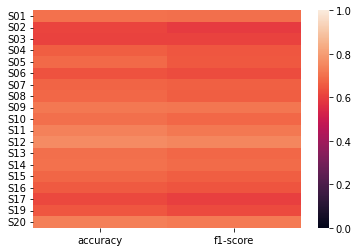

     class0 f1-score  class1 f1-score
S01         0.789474         0.489362
S02         0.734694         0.285714
S03         0.718367         0.355140
S04         0.772563         0.350515
S05         0.798450         0.297297
S06         0.756757         0.307692
S07         0.770428         0.438095
S08         0.782288         0.404040
S09         0.805861         0.485437
S10         0.792727         0.435644
S11         0.826772         0.450000
S12         0.838462         0.543478
S13         0.795455         0.425532
S14         0.793893         0.460000
S15         0.780669         0.391753
S16         0.764045         0.363636
S17         0.744939         0.258824
S19         0.760148         0.329897
S20         0.818182         0.500000


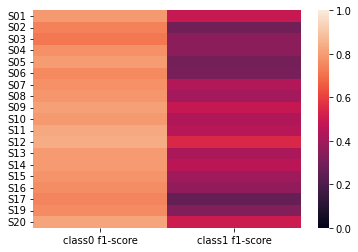

In [6]:
userfold_results_summary(participants_dictionary, participants)
userfold_classwise_results_summary(participants_dictionary, participants)
